# Conductance estimation of Ohara 2017 by EfficientNet

In [1]:
import os, sys, copy, time
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd
import seaborn as sns
import multiprocessing
from functools import partial
import cv2
import skimage.io
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
from torchvision import datasets, models, transforms
import torchvision.utils as vutils
import torchaudio.transforms as AT
from torch.utils.data import  Dataset, TensorDataset, DataLoader
from efficientnet_pytorch import EfficientNet
from typing import Type, Any, Callable, Union, List, Optional
from IPython.display import HTML
from IPython import display
import librosa.display
from tqdm import tqdm
from sklearn.model_selection import train_test_split

random.seed(3)
np.random.seed(3)
torch.manual_seed(3)

print(torch.__version__)

1.10.2+cu113


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
if (device.type == 'cuda') and (torch.cuda.device_count() >1):
    print("Multi GPU activate")
# device = torch.device('cpu')
device

Multi GPU activate


device(type='cuda')

In [3]:
def minmax_normalization(x, min=1.0, max=100.0):
    return (x - min) / (max - min)

def inv_minmax_normalization(x_std, min=1, max=100):
    return x_std * (max - min) + min 

In [4]:
batch_size = 64
epochs = 100
print_every = 1
window = 20
step_size = 10
window_type = 'avg'
emb_size = 512
d_model = 512
max_len = 2000
patience = 1000

dataset_list = ["Dataset1", "Dataset2" ]
models_dir = "Trained_models"
model_file_path = os.path.join(models_dir, f'params-100.pk')

In [5]:
output_dir1 = f'./{models_dir}/Results1_sim'        
if not os.path.exists(output_dir1):
    os.makedirs(output_dir1)
    print('"%s" has been created.'%(output_dir1))
output_dir2 = f'./{models_dir}/Results2_sim'        
if not os.path.exists(output_dir2):
    os.makedirs(output_dir2)
    print('"%s" has been created.'%(output_dir2))


In [6]:
x_data_OK = []
y_data_OK = []
x_data_NG = []
y_data_NG = []
for ds in dataset_list:
    ds_path = os.path.join("../Dataset", ds)    
    x_data_OK.append( np.load(os.path.join(ds_path, 'x_data_OK.npy')) )
    y_data_OK.append( np.load(os.path.join(ds_path, 'y_data_OK.npy')) )
    x_data_NG.append( np.load(os.path.join(ds_path, 'x_data_NG.npy')) )
    y_data_NG.append( np.load(os.path.join(ds_path, 'y_data_NG.npy')) )

x_data_OK = np.concatenate(x_data_OK, axis=0)
y_data_OK = np.concatenate(y_data_OK, axis=0)
x_data_NG = np.concatenate(x_data_NG, axis=0)
y_data_NG = np.concatenate(y_data_NG, axis=0)

print(x_data_OK.shape, y_data_OK.shape, x_data_NG.shape, y_data_NG.shape)

(1435, 47) (1435, 2) (70, 47) (70, 2)


In [7]:
start_time = time.time()

x_train_OK, x_val_test_OK, y_train_OK, y_val_test_OK = train_test_split(x_data_OK, y_data_OK, test_size=0.398, shuffle=False)
x_train_NG, x_val_test_NG, y_train_NG, y_val_test_NG = train_test_split(x_data_NG, y_data_NG, test_size=0.4, shuffle=False)
x_val_OK, x_test_OK, y_val_OK, y_test_OK = train_test_split(x_val_test_OK, y_val_test_OK, test_size=0.5, shuffle=False)
x_val_NG, x_test_NG, y_val_NG, y_test_NG = train_test_split(x_val_test_NG, y_val_test_NG, test_size=0.5, shuffle=False)

x_train = np.concatenate([x_train_OK, x_train_NG], axis=0)
y_train = np.concatenate([y_train_OK, y_train_NG], axis=0)
x_val = np.concatenate([x_val_OK, x_val_NG], axis=0)
y_val = np.concatenate([y_val_OK, y_val_NG], axis=0)
x_test = np.concatenate([x_test_OK, x_test_NG], axis=0)
y_test = np.concatenate([y_test_OK, y_test_NG], axis=0)

print(x_train_OK.shape, x_val_OK.shape, x_test_OK.shape)
print(x_train_NG.shape, x_val_NG.shape, x_test_NG.shape)
print(x_train.shape, x_val.shape, x_test.shape)

print(y_train_OK.shape, y_val_OK.shape, y_test_OK.shape)
print(y_train_NG.shape, y_val_NG.shape, y_test_NG.shape)
print(y_train.shape, y_val.shape, y_test.shape)

print("--- %s seconds ---"%(time.time()-start_time))

(863, 47) (286, 47) (286, 47)
(42, 47) (14, 47) (14, 47)
(905, 47) (300, 47) (300, 47)
(863, 2) (286, 2) (286, 2)
(42, 2) (14, 2) (14, 2)
(905, 2) (300, 2) (300, 2)
--- 0.009320497512817383 seconds ---


In [8]:
x_train = torch.tensor(x_train).type(torch.float)
y_train = torch.tensor(y_train).type(torch.float )
x_val = torch.tensor(x_val).type(torch.float)
y_val = torch.tensor(y_val).type(torch.float )
x_test = torch.tensor(x_test).type(torch.float)
y_test = torch.tensor(y_test).type(torch.float )

y_train = y_train.view(-1, 2)
y_val = y_val.view(-1, 2)
y_test = y_test.view(-1, 2)

print(x_train.shape, x_val.shape, x_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

torch.Size([905, 47]) torch.Size([300, 47]) torch.Size([300, 47])
torch.Size([905, 2]) torch.Size([300, 2]) torch.Size([300, 2])


In [9]:
class DefectInspector0(torch.nn.Module):
    def __init__(self,                            
                 in_size: int = 47,
                 out_size: int = 2,                                 
                 dropout: float = 0.1
                ):
        super(DefectInspector0, self).__init__()

        self.name = 'DefectInspector0'        
        self.out_size = out_size
        
        self.linear1 = torch.nn.Linear(in_size, 200)
        self.bn1 = torch.nn.BatchNorm1d(200)
        self.relu1 = torch.nn.ReLU(inplace=False)
        self.dropout1 = torch.nn.Dropout(dropout)
        
        self.linear2 = torch.nn.Linear(200, 200)
        self.bn2 = torch.nn.BatchNorm1d(200)
        self.relu2 = torch.nn.ReLU(inplace=False)
        self.dropout1 = torch.nn.Dropout(dropout)
        
        self.linear3 = torch.nn.Linear(200, 200)
        self.bn3 = torch.nn.BatchNorm1d(200)
        self.relu3 = torch.nn.ReLU(inplace=False)
        self.dropout1 = torch.nn.Dropout(dropout)
        
        self.final_linear = torch.nn.Linear(200, out_size, bias=True)  

    def forward(self, src: torch.Tensor): # src : (B, S, F)   
        
        out = self.linear1(src)       # (B, S, emb_size)      
        out = self.bn1(out)
        out = F.relu(out)
        
        out = self.linear2(out)       # (B, S, emb_size)      
        out = self.bn2(out)
        out = F.relu(out)
        
        out = self.linear3(out)       # (B, S, emb_size)      
        out = self.bn3(out)
        out = F.relu(out)
        
        return self.final_linear(out)       # (B, S, emb_size)      

In [10]:
# # val_ds = TensorDataset(x_val, y_val)
# test_ds = CustomDataset(x_test, y_test)
# test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=4) 
# print(test_ds[0][0].shape, test_ds[0][1].shape)

In [11]:
from torch.utils.data import  TensorDataset, DataLoader
test_ds = TensorDataset(x_test, y_test)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=0)
print(test_ds[0][0].shape, test_ds[0][1].shape)

torch.Size([47]) torch.Size([2])


In [12]:
model = DefectInspector0(in_size=x_test.shape[1],
                         out_size=y_test.shape[1])

In [13]:
checkpoint = torch.load(model_file_path) 
model.load_state_dict(checkpoint['model_state_dict'])

if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model, device_ids=[0,1])
model.to(device)

print(f"Training time : {checkpoint['time']}s ({checkpoint['time']/60/60}h)")

Training time : 91.72990036010742s (0.025480527877807618h)


Best MSE for train dataset
1 : (98, 0.001186)
2 : (99, 0.001199)
3 : (96, 0.001398)
4 : (97, 0.001421)
5 : (100, 0.001429)
6 : (95, 0.001445)
7 : (94, 0.001603)
8 : (92, 0.001676)
9 : (90, 0.001815)
10 : (91, 0.001818)
Best MSE for validation dataset
1 : (19, 0.114620)
2 : (18, 0.116024)
3 : (20, 0.117149)
4 : (17, 0.118664)
5 : (16, 0.122716)
6 : (51, 0.129964)
7 : (43, 0.131778)
8 : (54, 0.134069)
9 : (37, 0.134590)
10 : (46, 0.135812)
----------------------------------------------------------------------------------------------------
0.7292885184288025 0.0011859675869345665
2.486999988555908 0.11462032794952393


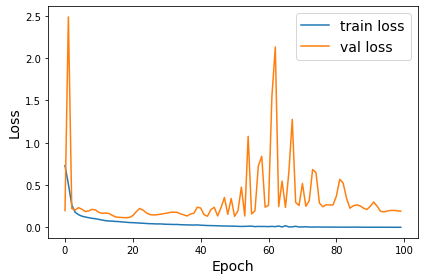

0.19099317491054535

In [14]:
train_loss_arr = np.array(checkpoint['train_loss_li'])
train_best_epoch = train_loss_arr.argsort() + 1
print("Best MSE for train dataset")
for i, epoch in enumerate(train_best_epoch[:10]):
    print("%d : (%d, %f)"%(i+1, epoch, train_loss_arr[epoch-1]))

print("="*50)

print("Best MSE for validation dataset")
val_loss_arr = np.array(checkpoint['val_loss_li'])
val_best_epoch = val_loss_arr.argsort() + 1
for i, epoch in enumerate(val_best_epoch[:10]):
    print("%d : (%d, %f)"%(i+1, epoch, val_loss_arr[epoch-1]))

print('-'*100)
print(train_loss_arr.max(), train_loss_arr.min())
print(val_loss_arr.max(), val_loss_arr.min())
# plt.title("Loss", fontsize=18) 
plt.xlabel( "Epoch", fontsize=14)
plt.ylabel( "Loss", fontsize=14)
# plt.ylim(0, 0.05)
plt.plot(checkpoint['train_loss_li'], label='train loss')
plt.plot(checkpoint['val_loss_li'], label='val loss')
plt.legend(fontsize=14)
plt.tight_layout()
plt.savefig( os.path.join(output_dir1, 'train_val_loss1.jpg'), dpi=199) 
plt.show()
checkpoint['val_loss_li'][-1]

In [15]:
# for i, loss in enumerate(zip(checkpoint['train_loss_li'], checkpoint['val_loss_li'])):
#     print(i+1, loss) 

In [16]:
def test(model, data_loader): 
    loss_sum = 0    
    criterion = nn.BCELoss()# nn.CrossEntropyLoss() #nn.MSELoss()
    nIter = 0
    nSuccess = 0
    with torch.no_grad(): 
        model.eval()   
        for i, data in enumerate(data_loader):
            output = model(data[0].to(device))     
            out = F.softmax(output, dim=1)            
            out_max, out_indices = torch.max(out.cpu(), dim=1)            
            target_max, target_indices = torch.max(data[1], dim=1)
#             print((out_indices!=target_indices))
#             print((out_indices!=target_indices).sum())
            nSuccess += (out_indices==target_indices).sum()
            loss = criterion(out, data[1].to(device))
            loss_sum += loss   
            nIter+=1                
    return nSuccess, loss_sum.item()/nIter

In [17]:
nSuccess, loss = test(model, test_loader)
nSuccess

tensor(289)

In [18]:
print( f"%.2f %%"%(nSuccess/x_test.shape[0]*100))

96.33 %


In [ ]:
final_model_file = None
final_model = None
final_loss = float('inf')
final_results = None

file_li = os.listdir(models_dir)
# modelNo_li = list(range(333, 334)) #list(range(11, 366)) val_loss_argsort
modelNo_li = val_best_epoch[:5]


test_loss_li = []
for epoch in modelNo_li:#len(file_li)+1):
   
    start_time = time.time()
    model_file = "params-%d.pk"%(epoch)    
    checkpoint = torch.load(os.path.join(models_dir, model_file ) )       ## Why is this getting slower?
    #checkpoint = torch.load(path, map_location=lambda storage, loc: storage)

    model.load_state_dict(checkpoint['model_state_dict'])                    
    model.to(device)

    loss, results  = test(model, test_loader)    
    test_loss_li.append((epoch, loss))
    if loss<final_loss:
        final_model_file = model_file
        final_model = model
        final_loss = loss
        final_results = results

    print("Loss for %s : %f"%(model_file, loss ) )
    print("--- %s seconds ---"%(time.time()-start_time))

# print("--- %s seconds ---"%(time.time()-start_time))

print("="*50)
print("Final model : %s"%(final_model_file))
print("Loss for test dataset :", final_loss)

In [ ]:
test_loss_arr = np.array(test_loss_li)
test_loss_sort = test_loss_arr[:, 1].argsort()
print("MSE for test dataset")
for i, epoch in enumerate(test_loss_sort[:5]):
    print("%d : (%d, %f)"%(i+1, test_loss_li[epoch][0], test_loss_li[epoch][1]))

test_loss_epoch_sort = test_loss_arr[test_loss_arr[:, 0].argsort()]

# aa = np.hstack([val_loss_arr, test_loss_arr])
plt.plot(np.arange(1, len(train_loss_arr)+1) , train_loss_arr, label='train_loss')    
plt.plot(np.arange(1, len(val_loss_arr)+1) , val_loss_arr, label='val_loss')
plt.plot(test_loss_epoch_sort[:, 0] , test_loss_epoch_sort[:, 1], label='test_loss')
plt.ylim(0, 0.005)
plt.legend()
plt.savefig( os.path.join(output_dir1, 'train_val_loss2.jpg'), dpi=199) 
plt.show()

In [ ]:
y_test.max()

In [ ]:
final_results.max()

In [ ]:
final_results = final_results.numpy()

In [ ]:
targets = y_test.numpy()

In [ ]:
mse = MSE(targets, final_results, axis=1)
bad_index = mse.argmax()
bad_mse = mse[mse.argmax()]
print(bad_index, bad_mse)

In [ ]:
print( targets[bad_index])

In [ ]:
print( final_results[bad_index])

In [ ]:
import matplotlib.cm as cm 
fig, ax = plt.subplots(3, 3, figsize=(15, 15))

# colors = cm.rainbow(np.linspace(0, 1, len(cell_li)))

# np.random.seed(2)
# colors = np.random.rand(targets.shape[0], 3)

# Marker size in units of points^2

# close = 0.003 * price_data.close[:-2] / 0.003 * price_data.open[:-2]

show_index = bad_index

for i in range(3):        
    for j in range(3):           
        if i==2 and j>0:
            continue
#             ax[i, j].set_xlim(-range_crit, range_crit)
#             ax[i, j].set_ylim(-range_crit, range_crit)  
        index = i*3 + j
        title = G_adj_li[index]
        x = targets[show_index, index]
        y = final_results[show_index, index]
                
        ax[i, j].set_title( "%s"%(title), fontsize=18)           
        ax[i, j].plot([0, 1], [0, 1], c='r')
        # ax[i, j].plot(x, y, c='r')
        ax[i, j].scatter(x, y, label="", c='k', s=30)            
        ax[i, j].set_xlabel( 'True', fontsize=14)
        ax[i, j].set_ylabel( "Prediction", fontsize=14)        
#         ax[i, j].legend()
        ax[i, j].grid(True)  
            
        # textstr = "MSE : %f"%(mse)
        # props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)        
        # ax[i, j].text(0.1, 0.95, textstr, transform=ax[i, j].transAxes, fontsize=18, verticalalignment='top', bbox=props)    
# plt.colorbar(label='color')
# fig.suptitle("Parameter estimation")
# fig1 = plt.gcf()
# plt.tight_layout()
plt.subplots_adjust(left=0.07, bottom=0.05, right=0.95, top=0.95, wspace=0.2, hspace=0.2)
plt.savefig( os.path.join(output_dir1, 'results1.jpg'), dpi=199) 
plt.show()

In [ ]:
import sklearn 
import scipy.stats as stats

mse_li = []
for i in range(final_results.shape[0]):
#     print(stats.pearsonr(y_test[i], final_results[i]))
#     print(y_test[i, 8], final_results[i, 8])    
    mse = MSE(targets[i], final_results[i], axis=0)
    mse_li.append(mse)
mse_li = np.array(mse_li)
    
#     pearson = stats.pearsonr(y_test[i], final_results[i])
#     pearson1 = stats.pearsonr(real_parameter[i], predicted_parameter[i])
# #     pearson2 = np.corrcoef(y_test[i], final_results[i])
        
#     cos_sim = cosine_similarity(y_test[i], final_results[i])
#     cos_sim1 = cosine_similarity(real_parameter[i], predicted_parameter[i])
    
#     if pearson[0] <= 1:     
#         print("mse : %f"%(mse))
#         print("pearson : %f, p-value : %f"%(pearson[0], pearson[1]))
#         print("pearson : %f, p-value : %f"%(pearson1[0], pearson1[1]))
# #         print(pearson2)
#         print("cos similarity : %f"%(cos_sim))
# #         print(real_parameter[i])
# #         print(predicted_parameter[i])
#         print("cos similarity : %f"%(cos_sim1))
#         print("="*50)
print(mse_li)
mse_argsort_reverse = mse_li.argsort()[::-1]

In [ ]:
index = 6
sum_temp = 0
for exact, pred in zip(targets[:, index], final_results[:, index]):
    sum_temp = abs(exact-pred)
    # if abs(exact-pred)>0.1:
    #     print(i, j)
sum_temp

In [ ]:
mse_results = MSE(targets[:100], final_results[:100], axis=0)
# print(mse_results.shape)
# print("cos similarity : %f"%(sklearn.metrics.pairwise.cosine_similarity(real_parameter, predicted_parameter)))
for i, p_name in enumerate(G_adj_li):    
    print(p_name)
    print("mse : %f"%(mse_results[i]))    
    # print("cos similarity : %f"%(cosine_similarity(targets[:, i], final_results[:, i])))
#     print("cos similarity : %f"%(cosine_similarity(real_parameter[:, i], predicted_parameter[:, i])))    
#     print("cos similarity : %f"%(sklearn.metrics.pairwise.cosine_similarity([real_parameter[:, i]], [predicted_parameter[:, i]])))
#     print(stats.pearsonr(real_parameter[:, i], predicted_parameter[:, i]))
#     print(stats.pearsonr(y_test[:, i], final_results[:, i]))    
    print("="*50)

In [ ]:
final_results.max()

In [ ]:
import matplotlib.cm as cm 
fig, ax = plt.subplots(3, 3, figsize=(15, 15))

# colors = cm.rainbow(np.linspace(0, 1, len(cell_li)))

np.random.seed(2)
colors = np.random.rand(targets.shape[0], 3)

# Marker size in units of points^2

# close = 0.003 * price_data.close[:-2] / 0.003 * price_data.open[:-2]

for i in range(3):        
    for j in range(3):           
        if i==2 and j>0:
            continue
#             ax[i, j].set_xlim(-range_crit, range_crit)
#             ax[i, j].set_ylim(-range_crit, range_crit)  
        index = i*3 + j
        title = G_adj_li[index]
        x = targets[:, index]
        y = final_results[:, index]
        mse = mse_results[index]
                
        ax[i, j].set_title( "%s"%(title), fontsize=18)           
        # ax[i, j].plot([0, 1], [0, 1], c='r')
        ax[i, j].scatter(x, y, label="", c=colors, s=30)            
        ax[i, j].set_xlabel( 'True', fontsize=14)
        ax[i, j].set_ylabel( "Prediction", fontsize=14)        
#         ax[i, j].legend()
        ax[i, j].grid(True)  
            
        textstr = "MSE : %f"%(mse)
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)        
        ax[i, j].text(0.1, 0.95, textstr, transform=ax[i, j].transAxes, fontsize=18, verticalalignment='top', bbox=props)    
# plt.colorbar(label='color')
# fig.suptitle("Parameter estimation")
# fig1 = plt.gcf()
# plt.tight_layout()
plt.subplots_adjust(left=0.07, bottom=0.05, right=0.95, top=0.95, wspace=0.2, hspace=0.2)
plt.savefig( os.path.join(output_dir1, 'results1.jpg'), dpi=199) 
plt.show()

In [ ]:
print("Finish")